# Different HVs

- COMSOL files in /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/refined_4mm/07.final_design.no_extraction.4mmFillet.100kV.0.2mesh.refined.0.5mA_out.mph

- HV is 60, 100, 130 kV

- bias voltage is -1.4 kV

- 0.5 mA ion beam current


In [1]:
fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/refined_4mm/particleData/07.final_design.no_extraction.4mmFillet.100kV.0.2mesh.refined.0.5mA_out.txt'

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']




## Function to process the COMSOL output (column headers with commas are a problem)

In [4]:
def preprocess_COMSOL_sweep(fname, sweep_vals):
    """
    fname: csv file of COMSOL output to read
    sweep_vals: what are the sweep values in a list
    
    Returns a dictionary with the dataframes qx qy qz for each file
    """
    
    # read the data and format the , correctly
    data = pd.read_csv(fname, skiprows=8, index_col=0, nrows=10, delimiter=r'\s+', header=None)
    with open(fname, 'r') as file:
        for line in file:
            if 'Index' in line:
                cols = line.rstrip().split(',')
                break
        file.close()
    col_str = ''.join(cols)
    col_str = col_str.replace('q', ' ,q')
    col_list = col_str.split(',')
    col_list = col_list[1:]



    # read the data again, use the columns found before as the headers
    data = pd.read_csv(fname, skiprows=8, index_col=0, header=None, delimiter=r'\s+')
    data.columns = col_list

    # filter the columns
    d_sweep = {}
    # dictionary of the dataframes, each dataframe is a separate sweep value
    dic_dfs = {}
    for val in sweep_vals:
        cols = [c for c in data.columns if val in c]
        d_sweep[val] = cols

    # add each dataframe to a separate place in the dictionary
    for key in d_sweep.keys():
        this_data = data.loc[:,d_sweep[key]]
        # rename the columns in qx, qy, qz
        new_cols = []
        for c in cols:
            if 'qx' in c:
                new_cols.append('qx')
            if 'qy' in c:
                new_cols.append('qy')
            if 'qz' in c:
                new_cols.append('qz')
        this_data.columns = new_cols

        dic_dfs[key] = this_data

    return dic_dfs

In [5]:
def preprocess_COMSOL(fname):
    """
    fname: csv file of COMSOL output to read
    
    Returns a dictionary with the dataframes qx qy qz for each file
    """
    
    # read the data and format the , correctly
    data = pd.read_csv(fname, skiprows=8, index_col=0, nrows=10, delimiter=r'\s+', header=None)
    with open(fname, 'r') as file:
        for line in file:
            if 'Index' in line:
                cols = line.rstrip().split(',')
                break
        file.close()
    col_str = ''.join(cols)
    col_str = col_str.replace('q', ' ,q')
    col_list = col_str.split(',')
    col_list = col_list[1:]



    # read the data again, use the columns found before as the headers
    data = pd.read_csv(fname, skiprows=8, index_col=0, header=None, delimiter=r'\s+')
    data.columns = col_list

    # rename the columns in qx, qy, qz
    new_cols = []
    for c in cols:
        if 'qx' in c:
            new_cols.append('qx')
        if 'qy' in c:
            new_cols.append('qy')
        if 'qz' in c:
            new_cols.append('qz')
    data.columns = new_cols


    return data

## Function to make the KDE plot

In [6]:
def make_plot_KDE(data, outfolder, figname, max_height, axis_lim):
    """
    Makes the gaussian kde and the y z plot.
    data is the dataframe with qx, qy, qz as headers and reach row is one sample data with the respecitve positions
    """
    nbins = 400
    lim = axis_lim
    #     print(data[pd.isnull(data).any(axis=1)])
    # save as csv
    data.to_csv(f'{outfolder}/{figname}.csv')
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#     print(zi.reshape(xi.shape))
    # plot
    fs = 24

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-lim,lim+1,1))
    plt.xticks(np.arange(-lim,lim+1,1))


    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40])
#     print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
    plt.savefig(f'{outfolder}/{figname}.pdf')
    plt.savefig(f'{outfolder}/{figname}.png', dpi=600)

    plt.show()

    # query from the estimated pdf
    qry_eval = np.linspace(-lim,lim,100)
    eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
    eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

    # fit FWHM
    def gauss(x, a, x0, sigma):
        return a * np.exp(-(x-x0)**2/(2*sigma**2))


    p0 = [1, 1, 1] # Initial guess for the parameters
    # fit for parallel to x axis
    X = qry_eval
    Y = eval_x
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_x, x0_x, sigma_x = popt
    Y_fit_x = gauss(X, *popt)
    FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in x: {FWHM_x}')

    # fit for parallel to y axis
    X = qry_eval
    Y = eval_y
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_y, x0_y, sigma_y = popt
    FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in y: {FWHM_y}')
    Y_fit_y = gauss(X, *popt)
#     print(gauss(x0_y, *popt), A_y)

    # make tophat
    X = qry_eval
    Y = np.zeros(len(X))
    for idx in range(len(X)):
        if (X[idx] >= -0.65) & (X[idx] <= 0.65):
            Y[idx] = 0.34

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, max_height)
    # top plot
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
#     plt.plot(qry_eval, Y_fit_x, '-.', color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot(X, Y, '-', color='darkred',linewidth=1.5, label='Top-hat fit')
    plt.plot([-0.65,0.65],[A_x/2,A_x/2], '--', color='black')
#     plt.text(-0.5, .1, f'FWHM = {FWHM_x:.2f} mm', fontsize=14)
    plt.text(-0.2, .15, r'\textbf{1.3 mm}', fontsize=16)
    
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,max_height+0.1,0.1))
    plt.xticks(np.arange(-2,3,1))
    leg1 = plt.legend(loc="best",  fontsize=16)
    plt.ylim(ylims)
    
    
    
    # bottom plot
    # make tophat
    X = qry_eval
    Y = np.zeros(len(X))
    for idx in range(len(X)):
        if (X[idx] >= -0.95) & (X[idx] <= 0.95):
            Y[idx] = 0.34
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
    plt.plot(X, Y, '-', color='darkred',linewidth=1.5, label='Top-hat fit')
    plt.plot([-0.95,0.95],[A_x/2,A_x/2], '--', color='black')
#     plt.text(-0.5, .1, f'FWHM = {FWHM_x:.2f} mm', fontsize=14)

#     plt.text(-0.45, .15, f'FWHM = {FWHM_y:.2f} mm', fontsize=16)
    plt.text(-0.15, .15, r'\textbf{1.9 mm}', fontsize=16)
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.5,0.1))
    plt.xticks(np.arange(-2,3,1))
    leg1 = plt.legend(loc="upper right",  fontsize=16)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
    plt.show()

,qx,qy,qz
0,,,
1,87.940053,0.046159,0.526007
2,87.940060,0.049056,0.487655
3,87.940068,0.052238,0.450711
4,87.940078,0.055734,0.414606
5,87.940079,0.056216,0.510287
...,...,...,...
4996,87.947363,-0.542649,-0.645717
4997,87.947078,-0.532050,-0.633868
4998,87.947290,-0.539934,-0.662675


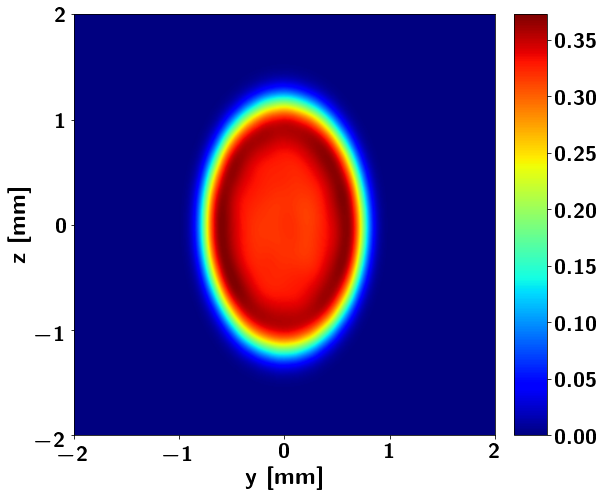

FWHM in x: 1.3413179148586047
FWHM in y: 2.0871214536304747


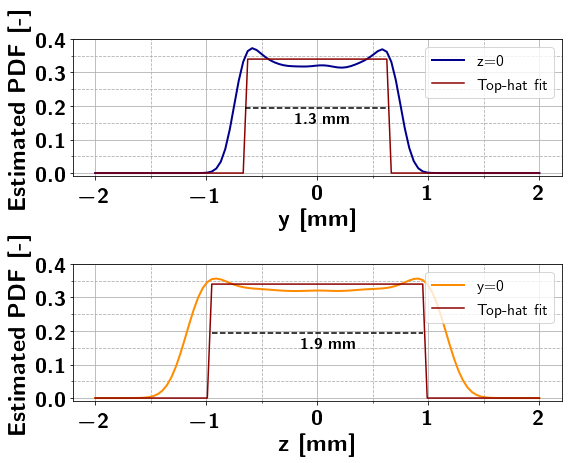

In [51]:
folder = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_Beam_Spot_100kV/'
figname = 'COMSOL_Beam_Spot_100kV'
make_plot_KDE(data, folder, figname, max_height=0.4, axis_lim=2)

In [11]:
fname = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_Beam_Spot_100kV/COMSOL_data.0.5mA_100kV.csv'
data = pd.read_csv(fname, index_col=0)
data

,qx,qy,qz
0,,,
1,87.940053,0.046159,0.526007
2,87.940060,0.049056,0.487655
3,87.940068,0.052238,0.450711
4,87.940078,0.055734,0.414606
5,87.940079,0.056216,0.510287
...,...,...,...
4996,87.947363,-0.542649,-0.645717
4997,87.947078,-0.532050,-0.633868
4998,87.947290,-0.539934,-0.662675


In [12]:
from scipy import optimize as opt

# def model(x, *p):
#     """
#     top hat function with four parameters that are:
#     # first parameter: base_level
#     # second parameter: hat_level
#     # third parameter: hat_mid
#     # forth parameter: hat_width
#     """
#     base_level, hat_level, hat_mid, hat_width = p

#     return np.where((hat_mid-hat_width/2. < x) & (x < hat_mid+hat_width/2.), hat_level, base_level)

# def model(x, *p):
#     """
#     top hat function with three parameters that are:
#     # first parameter: hat_level
#     # second parameter: hat_mid
#     # third parameter: hat_width
#     """
#     hat_level, hat_mid, hat_width = p
#     base_level = 0

#     return np.where((hat_mid-hat_width/2. < x) & (x < hat_mid+hat_width/2.), hat_level, base_level)
# def initial_guess(x, y):
#     """
#     For each of the parameters from the top hat fit function, make a guess for the value from a Normal distribution.
#     Returns the guessed parameters
#     """
#     params = []
    
# #     # first parameter: base_level
# #     params.append(np.random.normal(loc=np.min(y), scale=np.std(y)))   
#     # second parameter: hat_level
#     params.append(np.random.normal(loc=np.max(y), scale=np.std(y)))   
# #     params.append(np.max(y))   
#     # third parameter: hat_mid
#     params.append(np.random.normal(loc=0, scale=np.std(y)))   
#     # forth parameter: hat_width
#     params.append(np.random.normal(loc=np.std(x), scale=np.std(x)))   
    
    
#     return np.asarray(params)

def model(x, *p):
    """
    top hat function with three parameters that are:
    # first parameter: hat_level
    # second parameter: hat_right
    # third parameter: hat_left
    """
    hat_level, hat_right, hat_left = p
    base_level = 0

    return np.where((hat_left < x) & (x < hat_right), hat_level, base_level)

def initial_guess(x, y):
    """
    For each of the parameters from the top hat fit function, make a guess for the value from a Normal distribution.
    Returns the guessed parameters
    """
    params = []
    
    # first parameter: hat_level
    params.append(np.random.normal(loc=np.max(y), scale=np.std(y)))   
    # second parameter: hat_right
    params.append(np.random.normal(loc=np.std(x)/2, scale=np.std(y)))   
    # third parameter: hat_left
    params.append(np.random.normal(loc=-np.std(x)/2, scale=np.std(x)))   
    
    
    return np.asarray(params)

def loss_function(p, x_data, y_data, model):
    """
    Loss function is the total sum of squared differences between the data points (given as x_data, y_data and the predicted points.
    - p: model parameters
    - x_data, y_data: data points
    - model: function for the model (fit)
    """
    # predicted points
    y_pred = model(x_data, *p)

    loss = np.sum( (y_pred - y_data)**2 ) # total sum of squared differences

    return loss

def train(model, x_train, y_train, n_iter=3):
    p_best = None
    best_loss = 1e100
    for _ in range(n_iter):
        # The arguments that will get passed to the error function,
        # in addition to the model parameters of the current iteration.
        loss_fun_args = (x_train, y_train, model)
        p_initial = initial_guess(x=x_train, y=y_train)
        # Confusingly the `x0` argument is not expecting the x value of
        # the data points or for the 0th element of a list. It is for the
        # initial guess for the parameter values.
        res = opt.minimize(
            fun=loss_function,
            x0=p_initial,
            method="Nelder-Mead",
            args=loss_fun_args,
        )
        loss = loss_function(
            res.x,
            x_train,
            y_train,
            model,
        )
        if loss < best_loss:
            best_loss = loss
            p_best = res.x

    return p_best



def compare_models(x, y, n_iter=3):
    training_errors = []
    testing_errors = []
    
    x_train, y_train, x_test, y_test = x, y, x, y

    p_final = train(model, x_train, y_train)

    training_errors.append(loss_function(
            p_final, x_train, y_train, model))
    testing_errors.append(loss_function(
            p_final, x_test, y_test, model))


    return p_final, training_errors, testing_errors


def get_pdf_along_ax(data, nbins=400, eval_points=300, lim=4):
    """
    Takes the qx, qy, qz dataset and computes the pdf using a gaussian kernel density estimator. Then there is a slice along y and z which will be returned.
    - data: qx, qy, qz dataset as a dataframe from COMSOL
    - nbins: Number of bins to interpolate for the kde between -lim and lim
    - eval_points: how many evaluation points for the pdf along an axis
    - lim: extension of the gaussian kernel estimator 
    """
    
    Y = data['qy'].values # Y axis
    Z = data['qz'].values # Z axis
    my_data = np.vstack([Y, Z])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    qry_eval = np.linspace(-lim,lim,eval_points)

    eval_Y = [k.evaluate([x,0])[0] for x in qry_eval] 
    eval_Z = [k.evaluate([0,y])[0] for y in qry_eval] 
    
    return qry_eval, eval_Y, eval_Z

def plot_pdf(qry_eval, eval_Y, eval_Z, Y_vals, Z_vals):
    """
    takes the qry values and plots them for each axis
    """
    # Y axis
    p = Y_vals[0]
    Y = model(qry_eval, *p)
    plt.plot(qry_eval, Y, label='Y tophat', color='darkblue', ls='--')
    plt.plot(qry_eval, eval_Y, label='Y KDE', color='darkblue', alpha=0.75)
    plt.legend()
    plt.show()
    
    # Z axis
    p = Z_vals[0]
    Z = model(qry_eval, *p)
    plt.plot(qry_eval, Z, label='Z tophat', color='darkred', ls='--')
    plt.plot(qry_eval, eval_Z, label='Z KDE', color='darkred', alpha=0.75)
    
    plt.legend()
    plt.show()
    
    
def main(data, nbins=400, eval_points=300, lim=4, n_iter=3, plot=False, verbose=False):
    """
    Main function handler
    """
    qry_eval, eval_Y, eval_Z = get_pdf_along_ax(data, nbins, eval_points, lim)

    # model fit along Y
    Y_vals = compare_models(qry_eval, eval_Y, n_iter) # p_final, training_errors, testing_errors
    Z_vals = compare_models(qry_eval, eval_Z, n_iter) # p_final, training_errors, testing_errors
    
    if plot: plot_pdf(qry_eval, eval_Y, eval_Z, Y_vals, Z_vals)
    if verbose: print(Y_vals, Z_vals)
    return Y_vals, Z_vals

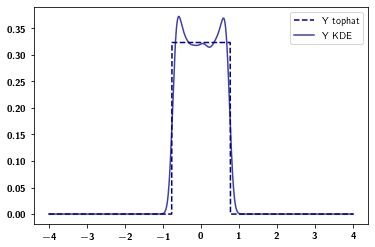

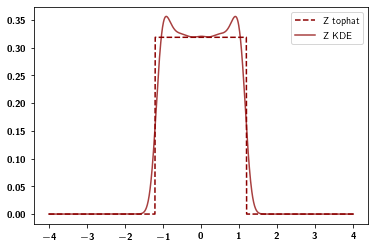

(array([ 0.32332658,  0.77054051, -0.7692389 ]), [0.5035674985947602], [0.5035674985947602]) (array([ 0.31888776,  1.19104329, -1.20866867]), [0.7405891753599114], [0.7405891753599114])


In [13]:
Y_vals, Z_vals = main(data, nbins=300, eval_points=1000, lim=4, n_iter=1e7, plot=True, verbose=True)

In [58]:
hat_top_y = Y_vals[0][0]
hat_right_y = Y_vals[0][1]
hat_left_y = Y_vals[0][2]
tophat_y = np.abs(hat_left_y-hat_right_y)

hat_top_z = Z_vals[0][0]
hat_right_z = Z_vals[0][1]
hat_left_z = Z_vals[0][2]
tophat_z = np.abs(hat_left_z-hat_right_z)
# first parameter: hat_level
# second parameter: hat_right
# third parameter: hat_left
ID = 1
hv = 100
s = pd.Series(index=['ID', 'hv', 'hat_top_y', 'hat_right_y', 'hat_left_y', 'hat_top_z', 'hat_right_z', 'hat_left_z', 'tophat_y', 'tophat_z'], data=[ID, hv, hat_top_y, hat_right_y, hat_left_y, hat_top_z, hat_right_z, hat_left_z, tophat_y, tophat_z])
data_tophat = pd.DataFrame(s).T

In [59]:
data_tophat

,ID,hv,hat_top_y,hat_right_y,hat_left_y,hat_top_z,hat_right_z,hat_left_z,tophat_y,tophat_z
0,1.0,100.0,0.323327,0.770541,-0.769239,0.318888,1.191043,-1.208669,1.539779,2.399712


In [73]:
def get_pdf_along_ax(data, nbins=400, eval_points=300, lim=4):
    """
    Takes the qx, qy, qz dataset and computes the pdf using a gaussian kernel density estimator. Then there is a slice along y and z which will be returned.
    - data: qx, qy, qz dataset as a dataframe from COMSOL
    - nbins: Number of bins to interpolate for the kde between -lim and lim
    - eval_points: how many evaluation points for the pdf along an axis
    - lim: extension of the gaussian kernel estimator 
    """
    
    Y = data['qy'].values # Y axis
    Z = data['qz'].values # Z axis
    my_data = np.vstack([Y, Z])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    qry_eval = np.linspace(-lim,lim,eval_points)

    eval_Y = [k.evaluate([x,0])[0] for x in qry_eval] 
    eval_Z = [k.evaluate([0,y])[0] for y in qry_eval] 
    
    return qry_eval, eval_Y, eval_Z

def make_final_plot(data, data_tophat, ID=12, hv=100, max_height=0.15, nbins=400, eval_points=300, lim=4):
    """
    Make the final tophat plot
    """
    
    fs = 30
    
    
    # get the qry data
    qry_eval, eval_Y, eval_Z = get_pdf_along_ax(data, nbins, eval_points, lim)
    
    # get the tophat data
    data_tophat = data_tophat[(data_tophat['ID'] == ID) & (data_tophat['hv'] == hv)]

    hat_right_y = data_tophat['hat_right_y'].values[0]
    hat_right_z = data_tophat['hat_right_z'].values[0]
    hat_left_y = data_tophat['hat_left_y'].values[0]
    hat_left_z = data_tophat['hat_left_z'].values[0]
    hat_top_y = data_tophat['hat_top_y'].values[0]
    hat_top_z = data_tophat['hat_top_z'].values[0]
    tophat_y = data_tophat['tophat_y'].values[0]
    tophat_z = data_tophat['tophat_z'].values[0]

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, max_height)

    # Y PLOT
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_Y, color='darkblue', linewidth=2.0, label=r'z=0 mm')
    
    X = np.linspace(-lim,lim,1000)
    Y = model(X, hat_top_y, hat_right_y, hat_left_y)
    
    plt.plot(X, Y, '-', color='darkred',linewidth=1.5, label=r'{Top-hat fit')
#     plt.plot([-w_y/2, w_y/2],[A_x/2,A_x/2], '--', color='black')
    tophat_y = np.round(tophat_y, 2)
    h = .1625
    plt.text(-0.55, h, r'\textbf{{{:.2f}}}'.format(tophat_y) + r' \textbf{mm}', fontsize=fs-8)
    plt.plot([hat_left_y, hat_right_y], [h-0.01, h-0.01], color='black', ls='--', lw=2)

    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF}' + '\n' + r'\textbf{[mm$^{-2}$]}', fontsize=fs-2)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,max_height+0.1,0.1))
    plt.xticks(np.arange(-3,3+1,1))
    leg1 = plt.legend(loc="upper right",  fontsize=16)
    plt.ylim(ylims)
    plt.xlim([-lim+1, lim-1])

  
    
    
    # Z PLOT
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_Z, color='darkorange', linewidth=2.0, label=r'y=0 mm')
    
    X = np.linspace(-lim,lim,1000)
    Y = model(X, hat_top_z, hat_right_z, hat_left_z)
    plt.plot(X, Y, '-', color='darkred',linewidth=1.5, label=r'Top-hat fit')

    tophat_z = np.round(tophat_z, 2)
    plt.text(-0.55, h, r'\textbf{{{:.2f}}}'.format(tophat_z) + r' \textbf{mm}', fontsize=fs-8)
    plt.plot([hat_left_z, hat_right_z], [h-0.01, h-0.01], color='black', ls='--', lw=2)
    
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF}' + '\n' + r'\textbf{[mm$^{-2}$]}', fontsize=fs-2)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.5,0.1))
    plt.xticks(np.arange(-3,3+1,1))
    leg1 = plt.legend(loc="upper left",  fontsize=16)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.xlim([-lim+1, lim-1])
    outfolder = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_Beam_Spot_100kV/'
    figname = 'COMSOL_Beam_Spot_100kV_THESIS_PLOT'
    plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
    plt.savefig(f'{outfolder}/{figname}_YZ.png', dpi=900)
    plt.show()

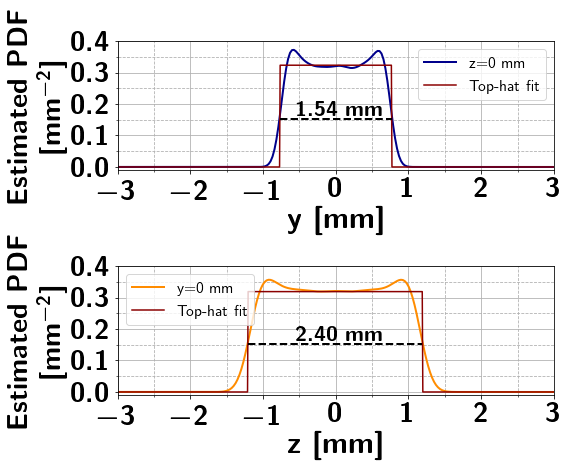

In [74]:
make_final_plot(data, data_tophat, ID=1, hv=100, max_height=0.4, nbins=400, eval_points=300, lim=4)

## Make the 2D Plot

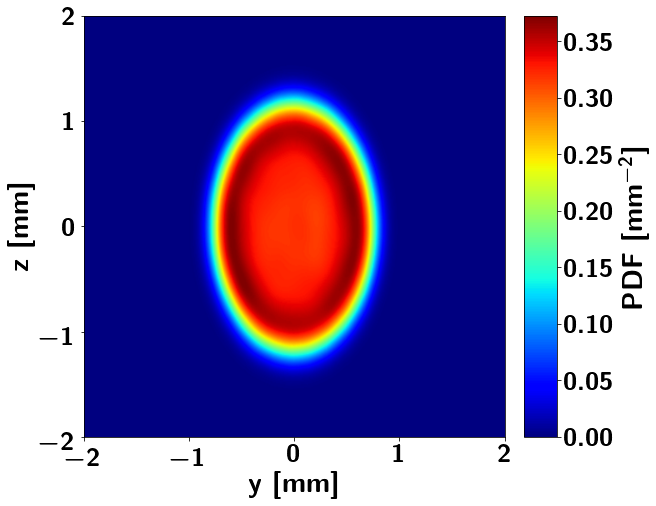

In [66]:
def make_plot_KDE(data, lim, nbins=400):

    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    #     print(zi.reshape(xi.shape))
    # plot
    fs = 28

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-lim,lim+1,1))
    plt.xticks(np.arange(-lim,lim+1,1))


    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=np.arange(0, 0.35+0.05, 0.05))
    #     print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
    cbar.set_label(r'\textbf{PDF [mm$^{-2}$]}', rotation=90, fontsize=fs)
    plt.savefig(f'/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_Beam_Spot_100kV/COMSOL_Beam_Spot_100kV_THESIS_PLOT.pdf')
    plt.savefig(f'/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_Beam_Spot_100kV/COMSOL_Beam_Spot_100kV_THESIS_PLOT.png', dpi=900)

    plt.show()
    
make_plot_KDE(data, lim=2, nbins=400)